## Overview

This notebook implements a **baseline model for predicting protein stability changes (ΔΔG) upon point mutations**, using the [Megascale dataset](https://www.biorxiv.org/content/10.1101/2022.12.12.520108).

### What is ΔΔG?
ΔΔG measures how much a single amino acid substitution destabilizes (or stabilizes) a protein. Negative values = stabilizing, positive = destabilizing.

---

### Pipeline

1. **Data Loading (`SequenceData`)** — Reads mutation data from CSV, groups mutations by wild-type protein, and encodes positions/amino acids into dense mask + target tensors of shape `(1, seq_len, 20)`.

2. **Baseline Model (`BlosumBaseline`)** — Instead of a learned model, uses the **BLOSUM62 substitution matrix** as a proxy for ΔΔG. For each position, it looks up the substitution score from the wild-type amino acid to each possible mutation. The intuition: evolutionarily unlikely substitutions (low BLOSUM score) should be more destabilizing.

3. **Evaluation** — Predictions are compared to experimental ΔΔG values using:
   - **RMSE** — magnitude of error
   - **Pearson r** — linear correlation
   - **Spearman r** — rank-order correlation

This serves as a simple, interpretable **benchmark** to compare against more sophisticated deep learning models.

## BLOSUM62 Matrix

**BLOSUM** (BLOcks SUbstitution Matrix) captures how frequently one amino acid is substituted for another during evolution across related protein sequences.

**BLOSUM62** specifically was built from protein sequence alignments with ~62% identity — meaning it learned substitution rates from moderately diverged proteins.

### How it works
- It's a **20×20 matrix** (one row/column per amino acid)
- Each entry `BLOSUM[A, B]` is a **log-odds score**: how much more likely is substitution A→B compared to random chance?
  - **High score** (e.g. Leu→Ile = +2): chemically similar, evolutionarily common swap
  - **Low/negative score** (e.g. Ala→Trp = −3): very different amino acids, rare substitution

### Why use it as a ΔΔG baseline?
The intuition is simple: **if evolution rarely tolerates a substitution, it probably destabilizes the protein.** So a low BLOSUM score is used as a rough proxy for a large (destabilizing) ΔΔG change.

It's not a perfect predictor — BLOSUM knows nothing about protein structure — but it's a fast, zero-parameter baseline that captures basic amino acid chemistry.

## Why Two Deltas? What is ΔΔG?

### Start with ΔG — folding stability
For any protein, **ΔG** is the free energy difference between the folded and unfolded state:
```
ΔG = G(unfolded) - G(folded)
```

A stable protein has a large positive ΔG — it strongly "prefers" to stay folded.

---

### Then ΔΔG — the *change* in stability from a mutation
When you introduce a point mutation, the folding energy changes. ΔΔG captures that shift:
```
ΔΔG = ΔG(mutant) - ΔG(wild-type)
```

- **ΔΔG > 0** → mutation destabilizes the protein (less stable than wild-type)
- **ΔΔG < 0** → mutation stabilizes the protein
- **ΔΔG ≈ 0** → neutral mutation

Two deltas because it's a **difference of differences** — hence ΔΔG.

---

### How is it measured experimentally?
The most common method is **thermal or chemical denaturation**:

1. Take your protein and gradually heat it (or add urea/guanidinium)
2. Measure the **melting curve** — the fraction of unfolded protein as a function of temperature or denaturant concentration
3. Fit the curve to extract ΔG for both the wild-type and mutant
4. Subtract → ΔΔG

The Megascale dataset does this at **massive scale** using fluorescence-based assays and deep mutational scanning, measuring thousands of mutations in parallel rather than one at a time.

# Imports

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.
The use of the dataloaders is explained in more detail in the other notebooks.

In [2]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence
        seq = mut_row["wt_seq"][0]

        # create mask and target tensors
        mask = torch.zeros((1, len(seq),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(seq),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(seq)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": seq, "mask": mask, "labels": target}

In [3]:
dataset_test = SequenceData('project_data/mega_val.csv')
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [5]:
# naive benchmark
# just use BLOSUM62 matrix to approximate ddG changes
from Bio.Align import substitution_matrices
substitution_matrix = substitution_matrices.load('BLOSUM62')

# helper functionality
# recompute the matrix to match our alphabet order
blosum_dict = {}
for wt_aa in aa_alphabet:
    blosum_dict[wt_aa] = torch.tensor([substitution_matrix[wt_aa,mut_aa] for mut_aa in aa_alphabet])

#print(blosum_dict)

class BlosumBaseline():
    # baseline model (not using pytorch bc it's not a deep learning model)
    def forward(self,sequence):
        
        prediction = torch.zeros((1,len(sequence),20))

        for i, aa in enumerate(sequence): # for each position in the sequence  
            # get BLOSUM substitution scores
            prediction[0,i] = blosum_dict[aa]

        return prediction


## Testing

To get a good feeling of how the model is performing and to compare with literature, compute the Pearson and Spearman correlations and the RMSE (root mean square error).

RMSE: 1.7409504146230437
Pearson r: PearsonRResult(statistic=np.float32(0.20027107), pvalue=np.float32(0.0))
Spearman r: SignificanceResult(statistic=np.float64(0.17113236420504885), pvalue=np.float64(1.1922885241415397e-178))


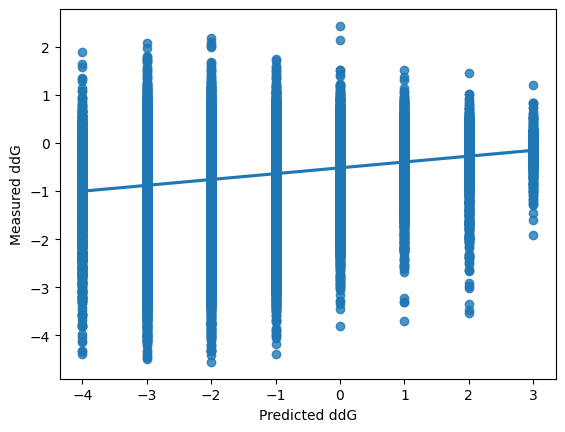

In [8]:
model = BlosumBaseline()

preds =[]
all_y = []

for batch in dataloader_test:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = model.forward(x)
    preds.append(prediction[mask==1].flatten().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
mse = skmetrics.mean_squared_error(all_y, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

## Baseline Results: BLOSUM62

The BLOSUM62 baseline performs poorly, as expected for such a simple model:

| Metric | Value |
|--------|-------|
| RMSE | 1.74 |
| Pearson r | 0.200 |
| Spearman r | 0.171 |

---

### Axes
- **X-axis (Predicted ddG):** The BLOSUM62 substitution score for a given amino acid swap.
  Since BLOSUM scores are integers, predictions can only take **discrete values** (e.g. −4, −3, −2, ...) — this is why the data forms vertical columns.
- **Y-axis (Measured ddG):** The experimentally measured stability change in kcal/mol — a continuous value.

---

### Each data point
Each point represents a **single point mutation** from the validation set.
- Its x-position = BLOSUM score for that substitution (wild-type AA → mutant AA)
- Its y-position = the actual experimentally measured ΔΔG for that mutation

---


Both correlations are statistically significant (p ≈ 0), meaning the BLOSUM scores carry *some* signal —
substitution biochemical similarity weakly tracks stability change. However, with r ≈ 0.2, the model
explains only ~4% of the variance in measured ddG (R² ≈ 0.04), so it has very little practical predictive power.

The scatter plot makes this clear: BLOSUM scores are **discrete integers** (hence the vertical stripes),
while measured ddG is **continuous** and spans a wide range (~−4.5 to +2.5 kcal/mol) at every predicted value.
The regression line has a positive slope but is nearly flat, confirming the weak trend.

An RMSE of ~1.74 kcal/mol is large relative to the scale of the data — a useful model should aim for
RMSE well below 1.0 kcal/mol. This sets the performance floor that any deep learning model must
substantially beat to be considered meaningful.

## Evaluation Metrics: RMSE vs Pearson vs Spearman

These three metrics capture different aspects of model performance.

---

### RMSE — Root Mean Square Error
```
RMSE = √( mean( (y_pred - y_true)² ) )
```
- Measures **absolute prediction error** in the same units as ΔΔG (kcal/mol)
- Penalizes large errors heavily (due to squaring)
- **Lower is better**
- Tells you: *"on average, how far off are my predictions?"*

---

### Pearson r — Linear Correlation
- Measures how well predictions follow a **linear relationship** with true values
- Ranges from −1 to +1
- Assumes both variables are normally distributed
- **Higher is better**
- Tells you: *"when ΔΔG goes up, does my prediction go up proportionally?"*

---

### Spearman r — Rank Correlation
- Measures whether predictions have the **correct ranking order**, regardless of scale
- Essentially Pearson computed on the *ranks* of the values instead of raw values
- More **robust to outliers** and doesn't assume linearity
- Ranges from −1 to +1
- Tells you: *"does my model correctly identify which mutations are more destabilizing than others?"*

---

### Why report all three?
| Metric | What it catches |
|--------|----------------|
| RMSE | Whether predictions are numerically accurate |
| Pearson | Whether the linear scale is correct |
| Spearman | Whether relative rankings are correct |

A model could rank mutations perfectly (high Spearman) but be systematically off by 1 kcal/mol (poor RMSE). For drug design you might care most about ranking; for thermodynamic modeling you'd care about RMSE.